## 커스텀 프로젝트 직접 만들기

In [1]:
import numpy
import transformers
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
print(numpy.__version__)
print(transformers.__version__)


1.23.0
4.33.1


### STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [2]:
from datasets import load_dataset

dataset = load_dataset("nsmc")

In [3]:
# 데이터 구조 확인
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [4]:
# 데이터 파싱
train_dataset = dataset["train"]
test_dataset = dataset["test"]

pd_train_dataset = pd.DataFrame(train_dataset)
pd_test_dataset = pd.DataFrame(test_dataset)

In [5]:
pd_train_dataset["label"].value_counts()

0    75173
1    74827
Name: label, dtype: int64

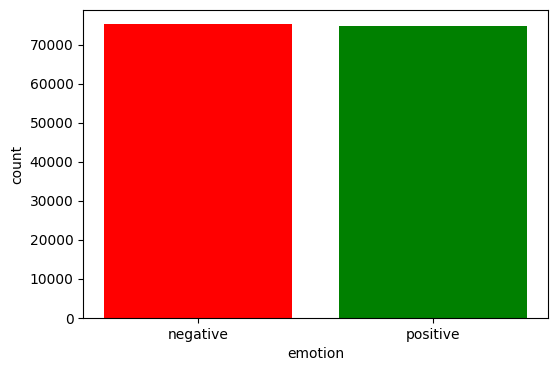

In [6]:
# 긍정, 부정 갯수 확인
label_counts = pd_train_dataset["label"].value_counts()
label_names = ['negative', 'positive']
plt.figure(figsize=(6, 4))
plt.bar(label_names, label_counts, color=['red', 'green'])
plt.xlabel("emotion")
plt.ylabel("count")
plt.show()

In [7]:
# 리뷰 문장 길이를 저장할 리스트 생성
review_lengths = []

# 각 리뷰의 길이를 계산하여 리스트에 추가
for review in train_dataset["document"]:
    review_lengths.append(len(review))

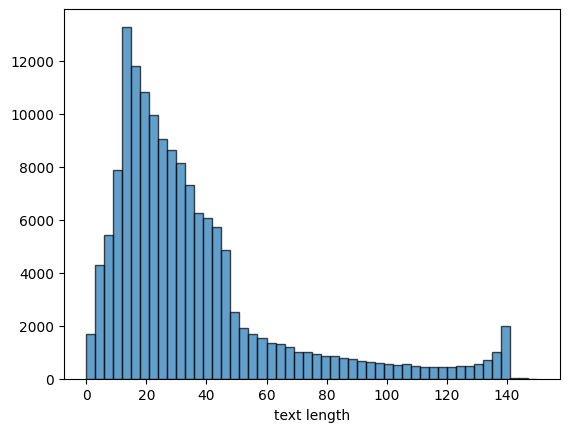

In [8]:
# 리뷰 길이의 분포를 시각화
plt.hist(review_lengths, bins=50, range=(0, 150), edgecolor='k', alpha=0.7)
plt.xlabel('text length')
plt.ylabel('')
plt.show()

### STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [10]:
# tokenizer 테스트
tokenizer("허니머스타드 소스")

{'input_ids': [2, 17945, 10065, 2256, 2343, 7140, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

### STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기

In [30]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True, # truncation은 특정 문장이 길어 모델을 다루기 힘들어 질 수 있으므로 짧게 자르는 것을 의미합니다.
        max_length=30,
        padding = 'max_length',
        return_token_type_ids = False,
        )

In [31]:
hf_dataset = dataset.map(transform, batched=True)

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [32]:
# 토크나이저 결과 확인
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [16]:
# 훈련2검증 데이터 분리
#train_data, valid_data = train_test_split(hf_dataset["train"], test_size=0.1, random_state=42)

In [33]:
# train & validation & test split
hf_train_dataset = hf_dataset['train']
#hf_val_dataset = valid_data
hf_test_dataset = hf_dataset['test']

#### 모델 설정 및 학습

In [34]:
from datasets import load_metric
metric = load_metric("accuracy")

# 훈련 중 정확도 계산 함수
def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids
    predictions = predictions.argmax(axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [35]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers/gyub'


# 훈련 파라미터 설정
training_args = TrainingArguments(
    output_dir=output_dir,  # 모델과 결과물 저장 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 64,   # 각 device 당 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)


In [37]:

# Trainer 객체 생성
trainer = Trainer(
    model=model,                         # 사용할 모델
    args=training_args,                  # 훈련 파라미터
    data_collator=None,                  # 데이터 콜렉터 (필요한 경우 설정)
    train_dataset=hf_train_dataset,         # 훈련 데이터셋
    eval_dataset=hf_test_dataset,
    compute_metrics = compute_metrics
)

trainer.train()
print("슝~")

/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.278700,0.264801,0.888140


/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


슝~


### STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기

In [42]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers/gyub'


# 훈련 파라미터 설정
training_args = TrainingArguments(
    output_dir=output_dir,  # 모델과 결과물 저장 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 128,   # 각 device 당 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.005,                        # weight decay
)


In [43]:

# Trainer 객체 생성
trainer = Trainer(
    model=model,                         # 사용할 모델
    args=training_args,                  # 훈련 파라미터
    data_collator=None,                  # 데이터 콜렉터 (필요한 경우 설정)
    train_dataset=hf_train_dataset,         # 훈련 데이터셋
    eval_dataset=hf_test_dataset,
    compute_metrics = compute_metrics
)

trainer.train()
print("슝~")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.234400,0.255050,0.893680


/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


슝~


### STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

In [54]:
from transformers import DataCollatorWithPadding
# 데이터 콜레이터 정의 (Bucketing을 포함한 패딩 적용)
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,  # 사용 중인 토크나이저
    padding=True,  # 패딩을 적용하도록 설정
    max_length=40,  # 버킷의 최대 길이를 지정
    pad_to_multiple_of=8,  # 패딩을 8의 배수로 적용
)

In [46]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers/gyub'


# 훈련 파라미터 설정
training_args = TrainingArguments(
    output_dir=output_dir,  # 모델과 결과물 저장 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 128,   # 각 device 당 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.005,                        # weight decay
)


In [50]:

# Trainer 객체 생성
trainer = Trainer(
    model=model,                         # 사용할 모델
    args=training_args,                  # 훈련 파라미터
    data_collator=data_collator,                  # 데이터 콜렉터 (필요한 경우 설정)
    train_dataset=hf_train_dataset,         # 훈련 데이터셋
    eval_dataset=hf_test_dataset,
    compute_metrics = compute_metrics,
)

trainer.train()
print("슝~")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.202300,0.253960,0.894500


/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


슝~


In [51]:
from transformers import DataCollatorWithPadding
# 데이터 콜레이터 정의 (Bucketing을 포함한 패딩 적용)
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,  # 사용 중인 토크나이저
    padding=True,  # 패딩을 적용하도록 설정
    max_length=80,  # 버킷의 최대 길이를 지정
    pad_to_multiple_of=8,  # 패딩을 8의 배수로 적용
    group_by_length=True,  # 시퀀스 길이에 따라 그룹화하도록 설정
)

In [52]:

# Trainer 객체 생성
trainer = Trainer(
    model=model,                         # 사용할 모델
    args=training_args,                  # 훈련 파라미터
    data_collator=data_collator,                  # 데이터 콜렉터 (필요한 경우 설정)
    train_dataset=hf_train_dataset,         # 훈련 데이터셋
    eval_dataset=hf_test_dataset,
    compute_metrics = compute_metrics,
)

trainer.train()
print("슝~")

/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.123700,0.271708,0.891360


/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/ubuntu/miniconda3/envs/pt112_py39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


슝~
